In [1]:
import sys
import pickle
import torch
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# path="/content/drive/My Drive/Colab Notebooks"
# os.chdir(path)
# os.listdir(path)
print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['..//', '..\\'])
print("Torch version: %s" % torch.__version__)

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)] on win32
Torch version: 2.0.1+cu118


In [2]:
from torch.utils.data import Dataset
from torch import nn
import utils
from torch.nn import functional as F
import random


def mergeEmbedding(sets_list, labels_list, embedding_types):
    all_embeddings_set = {}
    all_labels = []
    for t in embedding_types:
        all_embeddings_set[t] = []

    for embedding_set in sets_list:
        for t in embedding_types:
            all_embeddings_set[t] = all_embeddings_set[t] + embedding_set[t]
    for labels_set in labels_list:
        all_labels = all_labels + labels_set

    return all_embeddings_set, all_labels

def build_embedding_sets(filename, unique_labels=None):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    repo_names = list(data.keys())
    embedding_types = list(data[repo_names[0]].keys())[-5:]
    sequential_embeddings = {}
    labels = []

    for embedding in embedding_types:
        sequential_embeddings[embedding] = []

    for repo in repo_names:
        if unique_labels and data[repo]['topic'] not in unique_labels:
            continue
        labels.append(data[repo]['topic'])
        for embedding in embedding_types:
            sequential_embeddings[embedding].append(utils.sequential_embeddings(data[repo][embedding]))

    return sequential_embeddings, labels


def build_pair_data(data, labels, embedding_types, balanced=1.0):
    pair_embeddings = {}
    pair_labels = []

    def make_pair(idx1, idx2):
        if labels[idx1] != labels[idx2]:
            pair_labels.append(0)
        else:
            pair_labels.append(1)
        for embedding_type in embedding_types:
            e1 = data[embedding_type][idx1]
            e2 = data[embedding_type][idx2]
            pair_embeddings[embedding_type].append((e1, e2))

    for embedding_type in embedding_types:
        pair_embeddings[embedding_type] = []

    for i in range(len(labels)):
        make_pair(i, i)
        for j in range(i+1, len(labels)):
            make_pair(i, j)
            make_pair(j, i)

    if balanced:
        print("Before balanced:", len(pair_labels))
        c0_index = []
        c1_index = []
        for i in range(len(pair_labels)):
            if pair_labels[i] == 0:
                c0_index.append(i)
            else:
                c1_index.append(i)

        c0_num = len(c0_index)
        c1_num = len(c1_index)

        if c0_num > c1_num:
            c0_num = min(int(c1_num * balanced), c0_num)
            c0_index = random.sample(c0_index, c0_num)
        else:
            c1_num = min(int(c0_num * balanced), c1_num)
            c1_index = random.sample(c1_index, c1_num)

        print("C 0:", c0_num)
        print("C 1:", c1_num)

        balanced_index = c0_index + c1_index

        balanced_embeddings = {}
        balanced_labels = []
        for embedding_type in embedding_types:
            balanced_embeddings[embedding_type] = []


        for i in balanced_index:
            balanced_labels.append(pair_labels[i])
            for embedding_type in embedding_types:
                balanced_embeddings[embedding_type].append(pair_embeddings[embedding_type][i])

        pair_embeddings = balanced_embeddings
        pair_labels = balanced_labels
        print("After balanced:", len(pair_labels))

    return pair_embeddings, pair_labels


def split_pair_embeddings(pair_embeddings, pair_labels, train_test_ratio=0.8):
    half_index = len(pair_labels)//2
    split_index = int(train_test_ratio * half_index)
    train_pairs = {}
    valid_pairs = {}
    train_labels = pair_labels[:split_index] + pair_labels[half_index:half_index + split_index]
    valid_labels = pair_labels[split_index:half_index] + pair_labels[half_index + split_index:]
    for t in list(pair_embeddings.keys()):
        train_pairs[t] = pair_embeddings[t][:split_index] + pair_embeddings[t][half_index:half_index + split_index]
        valid_pairs[t] = pair_embeddings[t][split_index:half_index] + pair_embeddings[t][half_index + split_index:]
    print("Train set size:", len(train_labels))
    print("Validation set size:", len(valid_labels))
    return train_pairs, valid_pairs, train_labels, valid_labels

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
train_embeddings, trainLabels = build_embedding_sets("..//Dataset//repo_info_train_embeddings_reduce.pkl")
test_embeddings, testLabels = build_embedding_sets("..//Dataset//repo_info_test_embeddings_reduce.pkl")
valid_embeddings, validLabels = build_embedding_sets("..//Dataset//repo_info_validation_embeddings_reduce.pkl")

train_pair_embeddings, train_labels = build_pair_data(train_embeddings, trainLabels, embedding_types, balanced=1)
test_pair_embeddings, test_labels = build_pair_data(test_embeddings, testLabels, embedding_types, balanced=1)
valid_pair_embeddings, valid_labels = build_pair_data(valid_embeddings, validLabels, embedding_types, balanced=1)

all_embeddings, allLabels = mergeEmbedding([train_embeddings, test_embeddings, valid_embeddings], [trainLabels, testLabels, validLabels], embedding_types)
all_pair_embeddings, all_labels = build_pair_data(all_embeddings, allLabels, embedding_types, balanced=1)
train_pair_embeddings, valid_pair_embeddings, train_labels, valid_labels = split_pair_embeddings(all_pair_embeddings, all_labels)

Before balanced: 99225
C 0: 1173
C 1: 1173
After balanced: 2346
Before balanced: 1681
C 0: 59
C 1: 59
After balanced: 118
Before balanced: 10000
C 0: 192
C 1: 192
After balanced: 384
Before balanced: 207936
C 0: 2242
C 1: 2242
After balanced: 4484
Train set size: 3586
Validation set size: 898


In [5]:
from torch.utils.data import Dataset
from torch import nn


class MergePairDataset(Dataset):
    def __init__(self, data, labels, embedding_types):
        self.data = []
        for i in range(len(labels)):
            row = []
            for t in embedding_types:
                row.append((data[t][i][0], data[t][i][1]))
            self.data.append(row)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


class EmbeddingGRU(nn.Module):
    def __init__(self, num_hiddens, num_layers, dropout, size=768):
        super().__init__()
        self.net = nn.GRU(size, num_hiddens, num_layers, dropout=dropout, bidirectional=True)

    def forward(self, inputs, states):
        inputs = inputs.permute(1, 0, 2)
        _, last_state = self.net(inputs, states)
        return last_state


class StatesGRU(nn.Module):
    def __init__(self, num_hiddens, num_layers, dropout, size=768):
        super().__init__()
        self.net = nn.GRU(size, num_hiddens, num_layers, dropout=dropout, bidirectional=True)

    def forward(self, inputs, states):
        inputs = inputs.permute(1, 0, 2)
        states, last_state = self.net(inputs, states)
        return states, last_state


class MergeClassifier(nn.Module):

    def __init__(self, num_hiddens, num_layers, dropout, size=768 * 4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.device = device
        self.gru = StatesGRU(num_hiddens, num_layers, dropout, size=size)
        self.classifier = nn.Sequential(
            nn.Linear(num_hiddens * 2 * 100, num_hiddens * 2),
            nn.ReLU(),
            nn.BatchNorm1d(num_hiddens * 2),
            nn.Linear(num_hiddens * 2, 2),
        )

    def forward(self, input, states):
        e1 = []
        e2 = []
        for i in range(4):
            e1.append(input[i][0])
            e2.append(input[i][1])
        e1 = torch.cat(e1, dim=2).to(self.device)
        e2 = torch.cat(e2, dim=2).to(self.device)
        s1, last_states1 = self.gru(e1, states[0])
        s2, last_states2 = self.gru(e2, states[1])
        enc_output = torch.cat([s1, s2]).permute(1, 0, 2)
        enc_output = enc_output.reshape(enc_output.shape[0], -1)
        res = self.classifier(enc_output)
        return res, [last_states1, last_states2]

    def begin_state(self, device, batch_size=1):
        init_state = torch.zeros((2 * self.num_layers,
                                  batch_size, self.num_hiddens),
                                 device=device)
        return [init_state, init_state.clone().requires_grad_()]


class SingleClassifier(nn.Module):

    def __init__(self, num_hiddens, num_layers, dropout, embedding_index, size=768, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding_index = embedding_index
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.device = device
        self.net = EmbeddingGRU(num_hiddens, num_layers, dropout, size=size)
        self.classifier = nn.Sequential(
            nn.Linear(num_hiddens * num_layers * 2 * 2, num_hiddens * num_layers),
            nn.ReLU(),
            nn.Linear(num_hiddens * num_layers, num_hiddens * num_layers // 4),
            nn.ReLU(),
            nn.Linear(num_hiddens * num_layers // 4, num_hiddens * num_layers // 8),
            nn.ReLU(),
            nn.Linear(num_hiddens * num_layers // 8, 2),
        )

    def forward(self, input, states):
        e1, e2 = input[self.embedding_index]
        e1 = e1.to(self.device)
        e2 = e2.to(self.device)
        last_states1 = self.net(e1, states[0])
        last_states2 = self.net(e2, states[1])
        enc_output = torch.cat([last_states1, last_states2]).permute(1, 0, 2)
        enc_output = enc_output.reshape(enc_output.shape[0], -1)
        res = self.classifier(enc_output)
        return res, [last_states1, last_states2]

    def begin_state(self, device, batch_size=1):
        init_state = torch.zeros((2 * self.num_layers,
                                  batch_size, self.num_hiddens),
                                 device=device)
        return [init_state, init_state.clone().requires_grad_()]

cuda
codes_embeddings
Training starting
Epoch: 20, train loss: 0.005, validation loss: 0.006, train acc: 0.752, validation acc: 0.504
2632.0 examples/sec on cuda total training time:27.1 sec
Epoch: 40, train loss: 0.004, validation loss: 0.005, train acc: 0.800, validation acc: 0.608
2787.4 examples/sec on cuda total training time:53.5 sec
Epoch: 60, train loss: 0.004, validation loss: 0.005, train acc: 0.819, validation acc: 0.656
2750.2 examples/sec on cuda total training time:79.6 sec
Epoch: 80, train loss: 0.004, validation loss: 0.005, train acc: 0.839, validation acc: 0.686
2751.3 examples/sec on cuda total training time:105.9 sec
Epoch: 100, train loss: 0.003, validation loss: 0.004, train acc: 0.858, validation acc: 0.721
2643.1 examples/sec on cuda total training time:132.3 sec
Epoch: 120, train loss: 0.003, validation loss: 0.004, train acc: 0.862, validation acc: 0.723
2659.3 examples/sec on cuda total training time:158.8 sec
Epoch: 140, train loss: 0.003, validation loss: 0

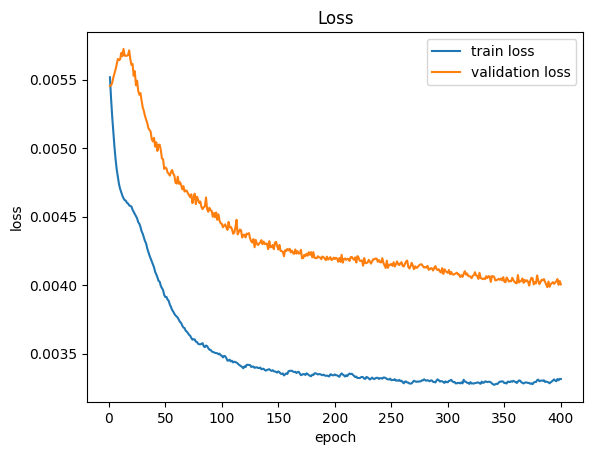

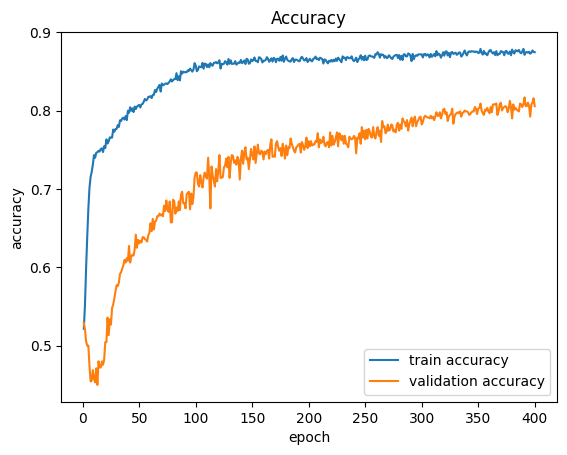

codes_embeddings
------------------------------
docs_embeddings
Training starting
Epoch: 20, train loss: 0.005, validation loss: 0.006, train acc: 0.699, validation acc: 0.480
2717.1 examples/sec on cuda total training time:26.4 sec
Epoch: 40, train loss: 0.005, validation loss: 0.006, train acc: 0.673, validation acc: 0.470
2708.7 examples/sec on cuda total training time:52.6 sec
Epoch: 60, train loss: 0.005, validation loss: 0.005, train acc: 0.654, validation acc: 0.493
2686.0 examples/sec on cuda total training time:79.4 sec
Epoch: 80, train loss: 0.005, validation loss: 0.005, train acc: 0.632, validation acc: 0.519
2752.7 examples/sec on cuda total training time:105.5 sec
Epoch: 100, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.499
2762.5 examples/sec on cuda total training time:131.6 sec
Epoch: 120, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.501
2797.9 examples/sec on cuda total training time:158.1 sec
Epoch: 

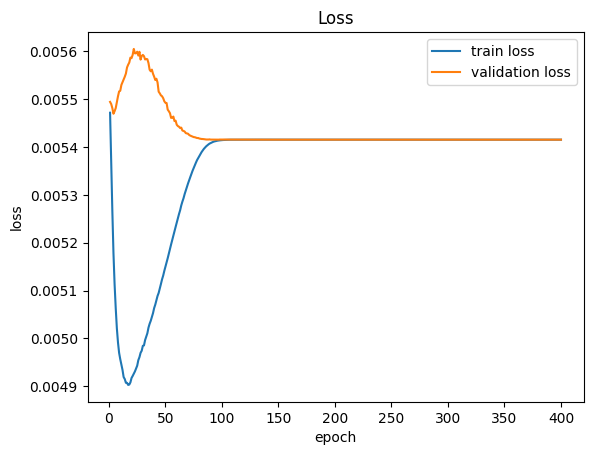

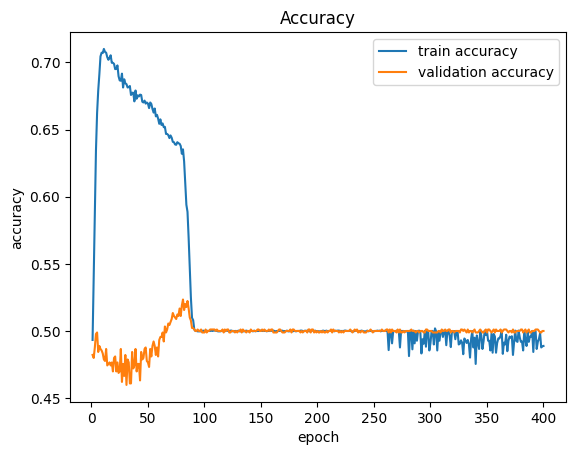

docs_embeddings
------------------------------
requirements_embeddings
Training starting
Epoch: 20, train loss: 0.005, validation loss: 0.005, train acc: 0.610, validation acc: 0.489
2659.9 examples/sec on cuda total training time:26.4 sec
Epoch: 40, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.499
2600.6 examples/sec on cuda total training time:52.6 sec
Epoch: 60, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.501
2694.2 examples/sec on cuda total training time:79.0 sec
Epoch: 80, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.500
2759.8 examples/sec on cuda total training time:105.2 sec
Epoch: 100, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.500
2779.6 examples/sec on cuda total training time:131.6 sec
Epoch: 120, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.500
2773.2 examples/sec on cuda total training time:157.9 sec


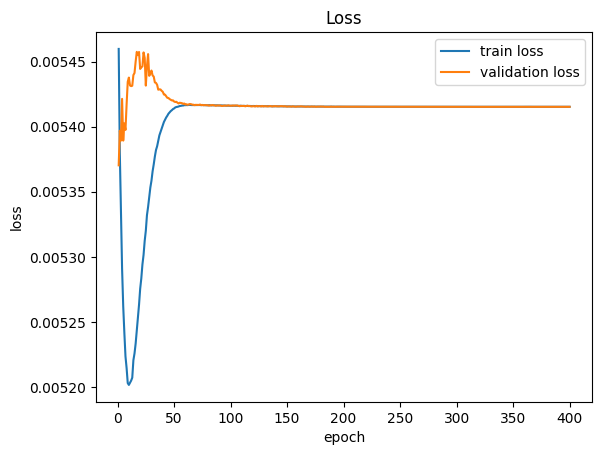

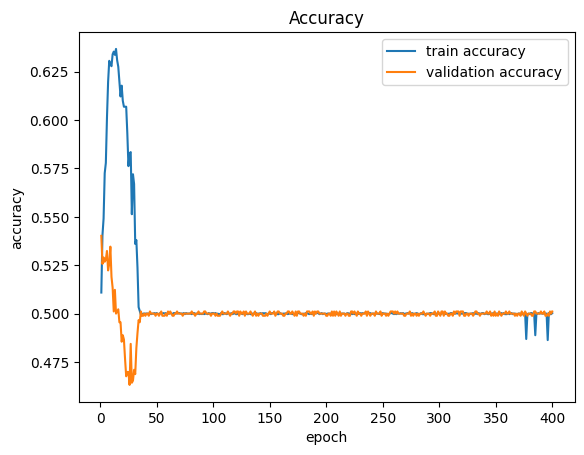

requirements_embeddings
------------------------------
readme_embeddings
Training starting
Epoch: 20, train loss: 0.005, validation loss: 0.005, train acc: 0.648, validation acc: 0.519
2685.3 examples/sec on cuda total training time:26.1 sec
Epoch: 40, train loss: 0.005, validation loss: 0.005, train acc: 0.603, validation acc: 0.537
2715.8 examples/sec on cuda total training time:52.5 sec
Epoch: 60, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.499
2752.1 examples/sec on cuda total training time:78.6 sec
Epoch: 80, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.500
2794.5 examples/sec on cuda total training time:104.7 sec
Epoch: 100, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.500
2774.6 examples/sec on cuda total training time:131.0 sec
Epoch: 120, train loss: 0.005, validation loss: 0.005, train acc: 0.500, validation acc: 0.501
2766.5 examples/sec on cuda total training time:157.5 se

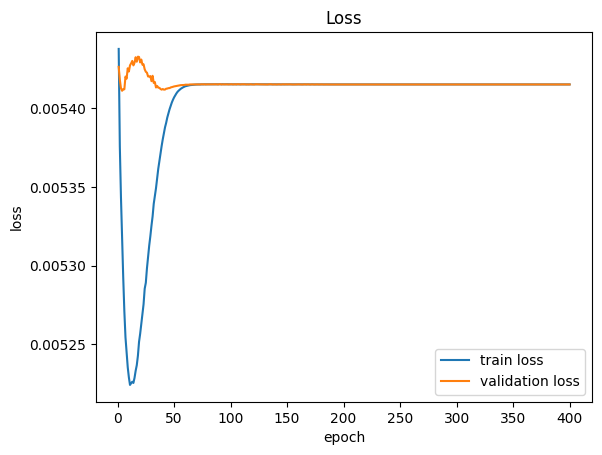

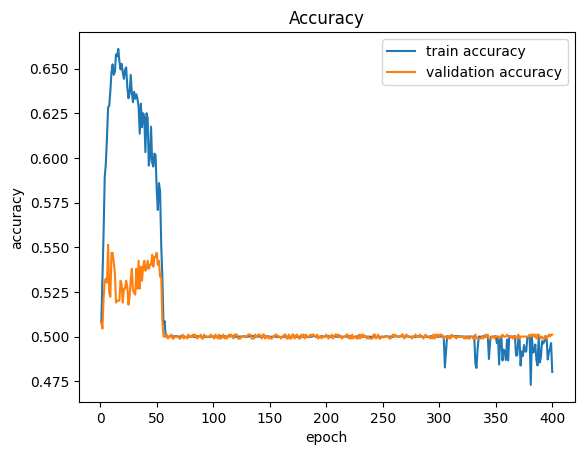

readme_embeddings
------------------------------


In [ ]:
from utils import train_rnn, drawGraph
from torch.utils.data import DataLoader

batch_size = 128
epochs = 400
lr = 0.0001
weight_decay = 0.1

num_hiddens = 256
num_layers = 2
dropout = 0.2

print(device)
train_dataset = MergePairDataset(train_pair_embeddings, train_labels, embedding_types)
valid_dataset = MergePairDataset(valid_pair_embeddings, valid_labels, embedding_types)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for idx, embedding_name in enumerate(embedding_types):
    print(embedding_name)
    net = SingleClassifier(num_hiddens, num_layers, dropout, idx, size=768)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
    train_loss, test_loss, train_acc, test_acc = utils.train_rnn(net, loss_fn, optimizer, epochs, device, train_loader,
                                                                 valid_loader, log_num=20, save_best=True,
                                                                 save_dir=embedding_name)
    drawGraph(train_loss, test_loss, train_acc, test_acc)
    print(embedding_name)
    print("-" * 30)

cuda
Training starting
Epoch: 1, train loss: 0.008, validation loss: 0.009, train acc: 0.548, validation acc: 0.492
1508.7 examples/sec on cuda total training time:2.4 sec
Epoch: 2, train loss: 0.009, validation loss: 0.009, train acc: 0.626, validation acc: 0.556
1647.7 examples/sec on cuda total training time:4.6 sec
Epoch: 3, train loss: 0.006, validation loss: 0.010, train acc: 0.730, validation acc: 0.602
1688.3 examples/sec on cuda total training time:6.7 sec
Epoch: 4, train loss: 0.005, validation loss: 0.008, train acc: 0.778, validation acc: 0.634
1692.0 examples/sec on cuda total training time:8.8 sec
Epoch: 5, train loss: 0.004, validation loss: 0.007, train acc: 0.799, validation acc: 0.671
1695.3 examples/sec on cuda total training time:10.9 sec
Epoch: 6, train loss: 0.003, validation loss: 0.007, train acc: 0.833, validation acc: 0.681
1653.4 examples/sec on cuda total training time:13.1 sec
Epoch: 7, train loss: 0.003, validation loss: 0.007, train acc: 0.843, validation

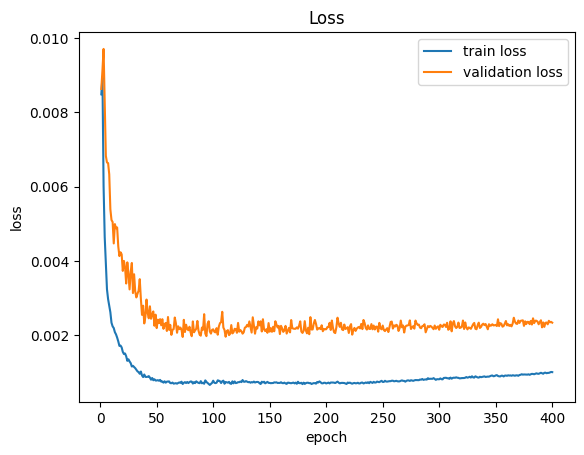

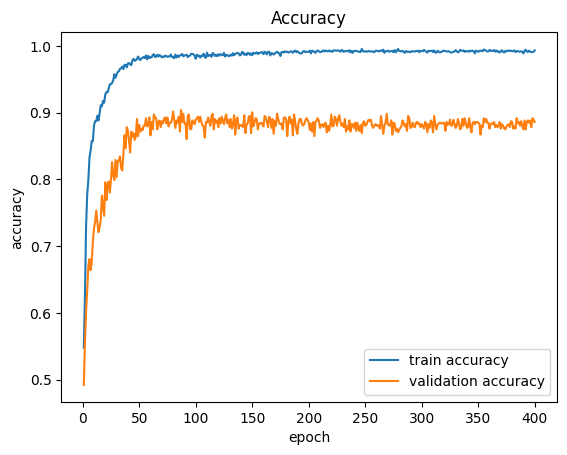

------------------------------


In [7]:
from utils import train_rnn, drawGraph
from torch.utils.data import DataLoader

batch_size = 128
epochs = 400
lr = 0.0001
weight_decay = 0.1

num_hiddens = 256
num_layers = 2
dropout = 0.2

print(device)
train_dataset = MergePairDataset(train_pair_embeddings, train_labels, embedding_types)
valid_dataset = MergePairDataset(valid_pair_embeddings, valid_labels, embedding_types)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


net = MergeClassifier(num_hiddens, num_layers, dropout, size=768*4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
train_loss, test_loss, train_acc, test_acc = utils.train_rnn(net, loss_fn, optimizer, epochs, device, train_loader,
                                                                 valid_loader, log_num=1, save_best=True,
                                                                 save_dir="TWINS_MODEL")
drawGraph(train_loss, test_loss, train_acc, test_acc)
print("-" * 30)

# Similarity Calculation

In [16]:
import torch
import utils
from torch.utils.data import DataLoader

batch_size = 64
num_hiddens = 256
num_layers = 2
dropout = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net = torch.load(".//TWINS_MODEL//Best_Model_2023-07-24 16-54-35.596111.pt").to(device)

net = MergeClassifier(num_hiddens, num_layers, dropout, size=768*4)
net.load_state_dict(torch.load(".//TWINS_MODEL//Best_Param_2023-07-24 16-54-35.596111.pt"))
net.eval()
net.to(device)
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']

with open("..//Dataset//repo_info_train_embeddings_reduce.pkl", "rb") as f:
    data = pickle.load(f)

repo_names = list(data.keys())

ri1 = 100
ri2 = 100

def similarity(repo1, repo2, data, net):
    embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
    input_data = [[],[],[],[]]
    matrix = [[],[]]
    for t in embedding_types:
        matrix[0].append(utils.sequential_embeddings(data[repo1][t]))
        matrix[1].append(utils.sequential_embeddings(data[repo2][t]))
    states = net.begin_state("cuda", batch_size=2)

    with torch.no_grad():
        for j in range(4):
            input_data[j] = []
            input_data[j].append(torch.stack([matrix[0][j], matrix[1][j]]))
            input_data[j].append(torch.stack([matrix[1][j], matrix[0][j]]))
        # if repo1 == repo2:
        #     print('Similarity of "{}" and "{}": {:.2f}%\n'.format(repo1, repo2, 100))
        #     return 1.0, 0.0
        res, _ = net(input_data, states)
        softmax = nn.Softmax(dim=1)
        similarity = torch.mean(softmax(res), dim=0)[1].cpu().numpy()
        dissimilarity = torch.mean(softmax(res), dim=0)[0].cpu().numpy()
    print('Similarity of "{}" and "{}": {:.2f}%\n'.format(repo1, repo2, similarity * 100))
    return similarity, dissimilarity

print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])

similarity(repo_names[ri1], repo_names[ri2], data, net)

django-cache-machine/django-cache-machine : Caching
django-cache-machine/django-cache-machine : Caching
Similarity of "django-cache-machine/django-cache-machine" and "django-cache-machine/django-cache-machine": 94.81%



(array(0.94813687, dtype=float32), array(0.05186307, dtype=float32))

In [17]:
ri1 = 100
ri2 = 168
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 121
ri2 = 168
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 121
ri2 = 100
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 168
ri2 = 32
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 200
ri2 = 32
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 200
ri2 = 121
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

sim_id = []
sim_list = []
for i in range(200):
    sim, _ = similarity(repo_names[i], repo_names[i], data, net)
    if sim > 0.95:
        sim_id.append(i)
        sim_list.append(sim)
print(len(sim_id))
print(sim_list)

django-cache-machine/django-cache-machine : Caching
deanmalmgren/textract : Web Content Extracting
Similarity of "django-cache-machine/django-cache-machine" and "deanmalmgren/textract": 2.92%

jazzband/django-pipeline : Web Asset Management
deanmalmgren/textract : Web Content Extracting
Similarity of "jazzband/django-pipeline" and "deanmalmgren/textract": 37.18%

jazzband/django-pipeline : Web Asset Management
django-cache-machine/django-cache-machine : Caching
Similarity of "jazzband/django-pipeline" and "django-cache-machine/django-cache-machine": 3.25%

deanmalmgren/textract : Web Content Extracting
keon/algorithms : Algorithms
Similarity of "deanmalmgren/textract" and "keon/algorithms": 15.52%

zoofIO/flexx : GUI Development
keon/algorithms : Algorithms
Similarity of "zoofIO/flexx" and "keon/algorithms": 9.33%

zoofIO/flexx : GUI Development
jazzband/django-pipeline : Web Asset Management
Similarity of "zoofIO/flexx" and "jazzband/django-pipeline": 66.17%

Similarity of "jet-admin/

Similarity of "Pylons/waitress" and "Pylons/waitress": 90.21%

Similarity of "SerpentAI/SerpentAI" and "SerpentAI/SerpentAI": 92.98%

Similarity of "html5lib/html5lib-python" and "html5lib/html5lib-python": 93.50%

Similarity of "dmlc/mxnet" and "dmlc/mxnet": 94.53%

Similarity of "django-haystack/pysolr" and "django-haystack/pysolr": 90.57%

Similarity of "aizvorski/scikit-video" and "aizvorski/scikit-video": 89.61%

Similarity of "sergree/matchering" and "sergree/matchering": 97.57%

Similarity of "ZoomerAnalytics/xlwings" and "ZoomerAnalytics/xlwings": 95.67%

Similarity of "jazzband/django-pipeline" and "jazzband/django-pipeline": 92.46%

Similarity of "clips/pattern" and "clips/pattern": 96.64%

Similarity of "fabianp/memory_profiler" and "fabianp/memory_profiler": 93.61%

Similarity of "mitsuhiko/unp" and "mitsuhiko/unp": 83.77%

Similarity of "stephenmcd/hot-redis" and "stephenmcd/hot-redis": 92.53%

Similarity of "henriquebastos/python-decouple" and "henriquebastos/python-decou

In [ ]:
from ignite.metrics import Accuracy
from ignite.metrics import Recall
from ignite.metrics import Precision

def evaluation(dataloader, model, loss_fn, device):
    test_acc = Accuracy()
    test_recall = Recall()
    test_precision = Precision()

    model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        print("Evaluation")
        for X, y in dataloader:
            states = net.begin_state("cuda", batch_size=X[0][0].shape[0])
            y = y.to(device)
            pred, _ = model(X, states)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_acc.update((pred, y))
            test_recall.update((pred, y))
            test_precision.update((pred, y))

    test_loss /= num_batches
    correct /= size

    # accuray,recall,precision in one epoach
    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, "
          f"Avg loss: {test_loss:>8f}, "
          f"ignite acc: {(100 * total_acc):>0.1f}%\n")
    print("recall of every test dataset class: ", total_recall)
    print("precision of every test dataset class: ", total_precision)

    test_precision.reset()
    test_acc.reset()
    test_recall.reset()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
all_pair_embeddings, all_labels = build_pair_data(all_embeddings, allLabels, embedding_types, balanced=False)
print("Size", len(all_labels))
all_dataset = MergePairDataset(all_pair_embeddings, all_labels, embedding_types)
dataloader = DataLoader(all_dataset, batch_size=512, shuffle=True, drop_last=False)
evaluation(dataloader, net, nn.CrossEntropyLoss(), device)

Size 207936
Evaluation
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.261334, ignite acc: 88.9%

recall of every test dataset class:  tensor([0.8880, 0.9888], dtype=torch.float64)
precision of every test dataset class:  tensor([0.9999, 0.0878], dtype=torch.float64)


In [ ]:
all_pair_embeddings, all_labels = build_pair_data(all_embeddings, allLabels, embedding_types, balanced=1.0)
print("Size", len(all_labels))
all_dataset = MergePairDataset(all_pair_embeddings, all_labels, embedding_types)
dataloader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
evaluation(dataloader, net, nn.CrossEntropyLoss(), device)

Before balanced: 207936
C 0: 2242
C 1: 2242
After balanced: 4484
Size 4484
Evaluation
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.183617, ignite acc: 94.2%

recall of every test dataset class:  tensor([0.8947, 0.9888], dtype=torch.float64)
precision of every test dataset class:  tensor([0.9877, 0.9038], dtype=torch.float64)


In [6]:
import torch
net = torch.load(".//TWINS_MODEL//Best_Model_2023-07-24 16-54-35.596111.pt").to(device)
torch.save(net.state_dict(), ".//TWINS_MODEL//Best_Param_2023-07-24 16-54-35.596111.pt")